Data sourced from Kaggle competition [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview)

In [53]:
# import core libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
import joblib

In [55]:
# pre-processing

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import nltk
from textblob import TextBlob
from langdetect import detect

import contractions

In [56]:
# modelling

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [57]:
# metrics/evaluation

import scikitplot as skplt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [58]:
# instantiating the train and test sets

train = pd.read_csv('data/train.csv')
test =  pd.read_csv('data/test.csv')

In [59]:
# combining the train and test sets for the purpose of EDA and Data Cleaning/Feature Engineering

df = pd.concat([train, test], ignore_index=True)

In [60]:
print("Training Dataframe Shape: {}".format(str(train.shape)))
print("Test Dataframe Shape: {}".format(str(test.shape)))
print("Combined Dataframe Shape: {}".format(str(df.shape)))

Training Dataframe Shape: (7613, 5)
Test Dataframe Shape: (3263, 4)
Combined Dataframe Shape: (10876, 5)


In [61]:
# example of tweets

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10876 non-null  int64  
 1   keyword   10789 non-null  object 
 2   location  7238 non-null   object 
 3   text      10876 non-null  object 
 4   target    7613 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 425.0+ KB


### Dealing with null values

In [63]:
# null values in the training set

df.isnull().sum()

id             0
keyword       87
location    3638
text           0
target      3263
dtype: int64

In [67]:
# creating a new category for the null keyword and location values

df.fillna({'keyword': 'unknown', 'location': 'unknown'},inplace=True)

### Keyword

In [74]:
keyword = df.keyword.apply(lambda x: "No" if x=="unknown" else "Yes")

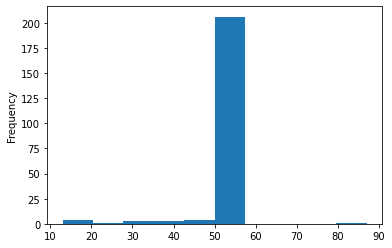

In [94]:
df.keyword.value_counts().plot.hist()

plt.show()

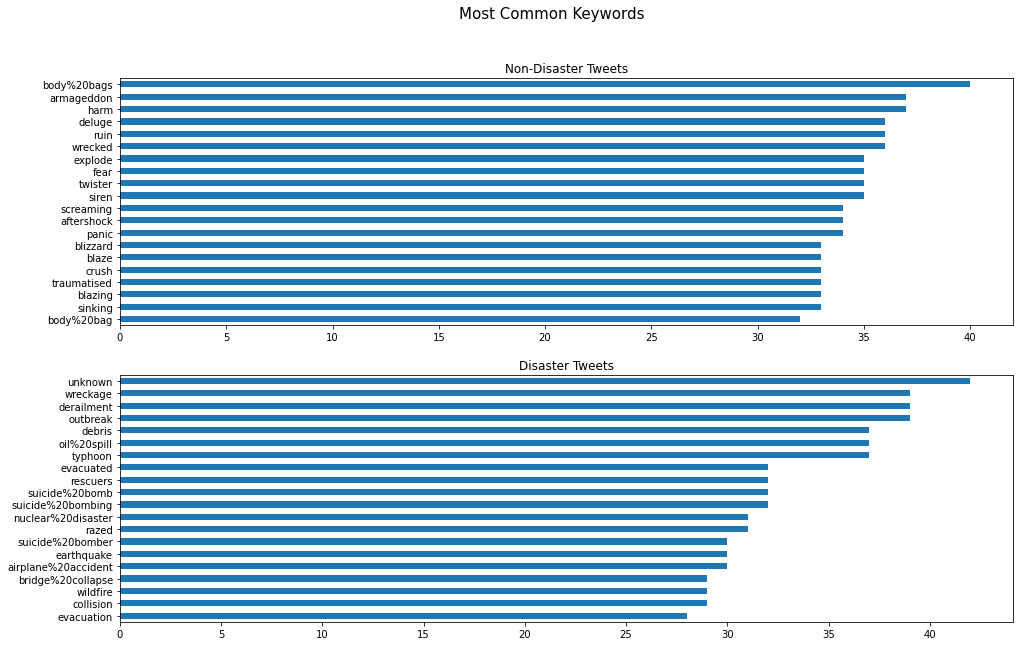

In [113]:
fig,ax = plt.subplots(2,1,figsize=(16,10))

df[df.target==0].keyword.value_counts(ascending=True).tail(20).plot.barh(ax=ax[0])
df[df.target==1].keyword.value_counts(ascending=True).tail(20).plot.barh(ax=ax[1])

ax[0].set_title('Non-Disaster Tweets')
ax[1].set_title('Disaster Tweets')

fig.suptitle('Most Common Keywords', fontsize=15)

plt.show()

In [117]:
# cleaning the keyword column

df.replace({'keyword': '%20'}, {'keyword': '_'}, inplace=True, regex=True)

In [123]:
df[df.keyword=='body_bags'].text.head()

1018    @FoxNews @JenGriffinFNC When you call to repor...
1019    Micom 2015 Summer Contrast Candy Color Bowknot...
1020    HOBO Hobo Vintage Shira Convertible BÛ_ $238....
1021    Child Shoulder Bags PVC Shoulder Book Bag Cart...
1022    Womens Buckle Casual Stylish Shoulder Handbags...
Name: text, dtype: object

My takings from this is that the keywords column won't be very helpful in determining whether a tweet is related to a disaster or not. I would theorize that the keywords were used to decide which tweets should be included in this dataset, though, as they refer to ambiguous topics that may or may not be natural disasters.

### Location

In [17]:
# given how messy and the location column is, it's unlikely that we'll be able to clean it for modelling purposes

df.location.value_counts().head(20)

unknown            3638
USA                 141
New York            109
United States        65
London               58
Canada               42
Nigeria              40
India                35
Worldwide            35
Los Angeles, CA      34
UK                   33
Kenya                32
Washington, DC       31
Mumbai               28
United Kingdom       26
California           25
Australia            25
Los Angeles          24
San Francisco        23
Chicago, IL          23
Name: location, dtype: int64

# Text

### Language

In [18]:
# checking that all tweets are in English

# lang_series = df.text.apply(lambda x: detect(x))

In [19]:
# saving lang_series as a joblib file

# joblib.dump(lang_series, 'jlib_files/lang_series.jlib')

In [20]:
# loading lang_series jlib file

lang_series = joblib.load('jlib_files/lang_series.jlib')

In [21]:
df['language'] = lang_series

In [22]:
df[df.language != 'en'].sample(5)

,id,keyword,location,text,target,language
10621,9936,trouble,??9?,Mouna gonna get me in trouble,NaN,fr
9606,6717,lava,Budgam kashmir,@Lavamobiles ..i have lava iris 3G 402,NaN,ca
831,1208,blizzard,unknown,Lizard Wizard in a Blizzard #LWB http://t.co/M...,0.0,it
7011,10050,twister,instagram: bribriony,Drunk twister is so hard ????,0.0,de
1109,1602,bombed,unknown,@BrodyFrieling @hanna_brooksie photo bombed,0.0,af


It seems that the language detector function isn't doing a very good job of picking up some of the tweets' language. Regardless, it seems that all of the tweets are in English so we don't have to worry about dealing with other languages.

In [23]:
# dropping language column from dataset

df.drop('language', 1, inplace=True)

### Using the tweet-preprocessor package

In [24]:
import preprocessor as p

### Cleaning tweets

In [25]:
# removing the tweet characteristics below from the tweets

p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.SMILEY, p.OPT.MENTION, p.OPT.RESERVED)

In [26]:
p.clean(df.text[31])

'Wholesale Markets ablaze'

In [27]:
df['text_clean'] = df.text.apply(lambda x: p.clean(x))

### Creating meta-data for tweet characteristics

In [28]:
tweet_tokenized = df.text.apply(lambda x:p.tokenize(x))

In [29]:
# creating a for-loop to add columns for the tweet meta-data features

for feature in ['url', 'smiley', 'mention']:
    feature_counter = []
    for tweet in tweet_tokenized:
        counter = 0
        for word in tweet.split():
            if word == "$"+feature.upper()+"$":
                counter += 1
        feature_counter.append(counter)
    df["tweet_"+feature] = feature_counter

### Meta-data for hash-tags

In [30]:
def hash_counter(x):
    counter = 0
    for word in x.split():
        if word[0] == '#' and len(word) > 1:
            counter += 1
    return counter

In [31]:
df['tweet_hashtag'] = df.text_clean.apply(hash_counter)

### Text meta-data: length of tweet, number of words and average word length

In [32]:
import string

In [33]:
df['tweet_characters'] = df.text_clean.apply(lambda x: len(x))

In [34]:
def word_counter(tweet):   
    no_punct = ''.join([x for x in tweet if x not in string.punctuation])
    word_lst = no_punct.split()      
    return len(word_lst)

In [35]:
df['tweet_words'] = df.text_clean.apply(word_counter)

In [36]:
words = ''.join([x for x in 'Our Deeds are the Reason of this #earthquake ' if x not in string.punctuation]).split()

In [37]:
sum(map(len, words))/len(words)

4.5

In [38]:
def ave_word_length(tweet):
    no_punct = ''.join([x for x in tweet if x not in string.punctuation])
    word_lst = no_punct.split()
    return sum(map(len, word_lst))/len(word_lst)

In [39]:
df['tweet_av_word_length'] = df.text_clean.apply(ave_word_length)

### Remove punctuation completely

In [ ]:
# removing punctuation from tweets

for punct in string.punctuation:
    df['text_clean'] = df.text_clean.str.replace(punct,'',regex=True)

### Removing digits

In [ ]:
df['no_num'] = df.text_clean.replace('\d+','',regex=True)

### Expanding contractions

In [ ]:
df['text_no_contr'] = df.no_num.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

### Tokenizing Tweets

In [ ]:
df['tokenized'] = df.text_no_contr.apply(nltk.word_tokenize)

### Change to lower-case

In [ ]:
df['lower'] = df.tokenized.apply(lambda x: [word.lower() for word in x])

### Removing stop words

In [ ]:
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
df['no_stop'] = df.lower.apply(lambda x: [word for word in x if word not in stop_words])

### Beginning the lemmatization process

In [ ]:
from nltk.corpus import wordnet

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
df['pos_tag'] = df.no_stop.apply(nltk.tag.pos_tag)

In [ ]:
wnl = WordNetLemmatizer()

In [ ]:
wnl.lemmatize('going', 'v')

In [ ]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
df['wordnet_pos'] = df['pos_tag'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [ ]:
df['lemmatized'] = df.wordnet_pos.apply(lambda x: ' '.join([wnl.lemmatize(word, tag) for word,tag in x]))

In [ ]:
df.head()

### Removing columns that are no longer needed

In [ ]:
df.columns

In [ ]:
df.drop(['keyword', 'location', 'text', 'text_clean', 'no_num', 'text_no_contr',
         'tokenized', 'lower', 'no_stop', 'pos_tag',
         'wordnet_pos'],axis=1, inplace=True)

# EDA

- seperate the below by each target variable
    - ~~number of characters in each tweet~~
    - ~~average word length in each sentence~~
    - ~~most commonly appearing ngrams of various lenghts~~
    - textblob for sentiment analysis
    - ~~frequency of most common words~~
- word clouds for each target variable

In [ ]:
tweet_md = ['tweet_url', 'tweet_smiley', 'tweet_mention', 'tweet_hashtag']

In [ ]:
target_gb = df.groupby('target').mean()
target_gb

In [ ]:
fig, ax = plt.subplots(4, 1, figsize = (16,14))

target_gb['tweet_url'].plot.barh(ax=ax[0], color= ['g','r'])
target_gb['tweet_smiley'].plot.barh(ax=ax[1], color= ['g','r'])
target_gb['tweet_mention'].plot.barh(ax=ax[2], color= ['g','r'])
target_gb['tweet_hashtag'].plot.barh(ax=ax[3], color= ['g','r'])

features = ['URLs', 'Smileys', 'Mentions', 'Hashtags']

for i, feature in zip(range(4), features):
    ax[i].set_title(feature, fontsize=15)
    ax[i].set_yticklabels(labels=['Not A Disaster Tweet', 'Disaster Tweet'])
    ax[i].set_ylabel(None)

fig.tight_layout(h_pad=3)
fig.suptitle('Average No. of Times Tweet Features Appear',x= 0.5, y=1.03, fontsize=20)

plt.show()

In [ ]:
target_gb

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (16,10))

target_gb['tweet_characters'].plot.barh(ax=ax[0], color= ['g','r'])
target_gb['tweet_words'].plot.barh(ax=ax[1], color= ['g','r'])
target_gb['tweet_av_word_length'].plot.barh(ax=ax[2], color= ['g','r'])

features = ['No. of Characters', 'No. of Words', 'Average Word Length']

for i, feature in zip(range(3), features):
    ax[i].set_title(feature, fontsize=15)
    ax[i].set_yticklabels(labels=['Not A Disaster Tweet', 'Disaster Tweet'])
    ax[i].set_ylabel(None)

fig.tight_layout(h_pad=3)
fig.suptitle('Text Meta-data',x= 0.5, y=1.05, fontsize=20)

plt.show()

# Add histogram comparisons to the above

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,6))

df[df.target==0.0].tweet_characters.hist(ax=ax[0],color='g',grid=False)
df[df.target==1.0].tweet_characters.hist(ax=ax[1],color='r',grid=False)

ax[0].set_title('Non-Disaster Tweet')
ax[1].set_title('Disaster Tweet')
fig.suptitle('No. of Characters in Tweet', fontsize=15)

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,6))

df[df.target==0.0].tweet_words.hist(ax=ax[0],color='g',grid=False)
df[df.target==1.0].tweet_words.hist(ax=ax[1],color='r',grid=False)

ax[0].set_title('Non-Disaster Tweet')
ax[1].set_title('Disaster Tweet')
fig.suptitle('No. of Words in Tweet', fontsize=15)

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,6))

df[df.target==0.0].tweet_av_word_length.hist(ax=ax[0],color='g',grid=False)
df[df.target==1.0].tweet_av_word_length.hist(ax=ax[1],color='r',grid=False)

ax[0].set_title('Non-Disaster Tweet')
ax[1].set_title('Disaster Tweet')
fig.suptitle('Average Word Length in Tweet', fontsize=15)

plt.show()

In [ ]:
df.rename({'lemmatized': 'text'}, axis=1, inplace=True)

# Countvectorize

### Unigrams

In [ ]:
cvec_1 = CountVectorizer(strip_accents='unicode', ngram_range=(1,1), max_df=1.0, min_df=1)

In [ ]:
matrix = cvec_1.fit_transform(df.text)

In [ ]:
len(cvec_1.get_feature_names())

In [ ]:
df_cvec_1 = pd.DataFrame(matrix.toarray(), columns = cvec_1.get_feature_names())

In [ ]:
df_cvec_1['df_target'] = df.target

In [ ]:
top_words_0 = df_cvec_1.groupby('df_target').sum().loc[0.0].sort_values(ascending=True).tail(20)
top_words_1 = df_cvec_1.groupby('df_target').sum().loc[1.0].sort_values(ascending=True).tail(20)

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(16,12))

top_words_0.plot.barh(ax=ax[0], fontsize=13)
top_words_1.plot.barh(ax=ax[1], fontsize=13)

ax[0].set_title('20 Most Frequently Appearing Unigrams for Non-Disaster Tweets', fontsize=15)
ax[1].set_title('20 Most Frequently Appearing Unigrams for Disaster Tweets', fontsize=15)

plt.show()

### Bigrams

In [ ]:
cvec_2 = CountVectorizer(strip_accents='unicode', ngram_range=(2,2), max_df=1.0, min_df=1)

In [ ]:
matrix_2 = cvec_2.fit_transform(df.text)

In [ ]:
len(cvec_2.get_feature_names())

In [ ]:
df_cvec_2 = pd.DataFrame(matrix_2.toarray(), columns = cvec_2.get_feature_names())

In [ ]:
df_cvec_2['df_target'] = df.target

In [ ]:
top_bigrams_0 = df_cvec_2.groupby('df_target').sum().loc[0.0].sort_values(ascending=True).tail(20)
top_bigrams_1 = df_cvec_2.groupby('df_target').sum().loc[1.0].sort_values(ascending=True).tail(20)

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(16,12))

top_bigrams_0.plot.barh(ax=ax[0], fontsize=13)
top_bigrams_1.plot.barh(ax=ax[1], fontsize=13)

ax[0].set_title('20 Most Frequently Appearing Bigrams for Non-Disaster Tweets', fontsize=15)
ax[1].set_title('20 Most Frequently Appearing Bigrams for Disaster Tweets', fontsize=15)

plt.show()

## Trigrams

In [ ]:
cvec_3 = CountVectorizer(strip_accents='unicode', ngram_range=(3,3), max_df=1.0, min_df=1)

In [ ]:
matrix_3 = cvec_3.fit_transform(df.text)

In [ ]:
len(cvec_3.get_feature_names())

In [ ]:
df_cvec_3 = pd.DataFrame(matrix_3.toarray(), columns = cvec_3.get_feature_names())

In [ ]:
df_cvec_3['df_target'] = df.target

In [ ]:
top_trigrams_0 = df_cvec_3.groupby('df_target').sum().loc[0.0].sort_values(ascending=True).tail(20)
top_trigrams_1 = df_cvec_3.groupby('df_target').sum().loc[1.0].sort_values(ascending=True).tail(20)

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(16,12))

top_trigrams_0.plot.barh(ax=ax[0], fontsize=13)
top_trigrams_1.plot.barh(ax=ax[1], fontsize=13)

ax[0].set_title('20 Most Frequently Appearing Trigrams for Non-Disaster Tweets', fontsize=15)
ax[1].set_title('20 Most Frequently Appearing Trigrams for Disaster Tweets', fontsize=15)

plt.show()

Notes - get appears a lot - is this important? Get rid?

Need to remove the 'amp;' thing - what other characters might be here?

## Sentiment Analysis

# VISUALISE MORE!!!

### To-do list:

- create broader categories for the keyword and, potentially, location columns
- use more visualizations through the data cleaning process (to start with: countvectorize before any data cleaning has started to show the words that appear the most frequently)


#### Text Pre-processing

- ~~check the language that the tweet is written in~~
- ~~remove digits~~
- ~~expand contractions~~
- ~~convert to lowercase~
- ~~remove punctuation~~ (maybe include meta-data for punctuation instead?)
- ~~tokenize words~~
- ~~lemmatize words~~
- ~~remove stop-words~~
- ~~hashtag extraction~~

- ~~does the text contain emojis?~~

#### Feature Engineering

- ~~meta-data~~
    - - ~~how many hash-tags each tweet contains~~
    - ~~no. of emojis~~
    - ~~number of words~~
    - ~~number of characters~~
- convert keyword column using techniques discussed here: https://www.kaggle.com/bandits/using-keywords-for-prediction-improvement
- ~~average word length~~
- use spacy to extract location from location variable

#### EDA

- before data cleaning - show number of tweets for each class
- do more basic visualisations to back up decisions
- word clouds for each target variable
- ~~seperate the below by each target variable~~
    - ~~number of characters in each tweet (make histogram)~~
    - ~~average word length in each sentence (make histogram)~~
    - ~~most commonly appearing ngrams of various lengths~~
    - ~~use speech tagging~~
    - ~~frequency of most common words~~
    
#### Other

- Research the use of LDA and NMF
    
    
Useful articles: 

https://towardsdatascience.com/preprocessing-text-data-using-python-576206753c28

https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e

https://medium.com/spatial-data-science/how-to-extract-locations-from-text-with-natural-language-processing-9b77035b3ea4



TBC: https://towardsdatascience.com/preprocessing-text-data-using-python-576206753c28